In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


In [3]:
df = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

In [5]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
df[df['toxic'] == 1].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


In [7]:
df[df['threat'] == 1].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
79,003217c3eb469ba9,Hi! I am back again!\nLast warning!\nStop undo...,1,0,0,1,0,0
176,006b94add72ed61c,I think that your a Fagget get a oife and burn...,1,0,1,1,1,1
600,0199d6af27b715f3,I'm also a sock puppet of this account...SUPRI...,1,0,0,1,0,0
802,02230885017a50c5,"Fuck you, Smith. Please have me notified when ...",1,0,1,1,1,0
1017,02c6e41e4b317ac3,WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'L...,1,1,1,1,1,1


In [8]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [9]:
df.shape

(159571, 8)

**We can't train a model with this much data so we have to use subset of data or use batch processing**

In [10]:
df = df.iloc[:60000].reset_index(drop = True)

In [11]:
df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
59995,a0969d4e7a6aa239,""":: I haven't read this book myself, but Heinl...",0,0,0,0,0,0
59996,a097921784642b56,Considering there were about 1000-5000 aid wor...,0,0,0,0,0,0
59997,a097cf61dac66f09,"|listas = Greene, Cornelius",0,0,0,0,0,0
59998,a099aa968d659b40,"I have no penis, I have no penis, I have no pe...",1,0,1,0,0,0
59999,a09a0a89a424dec8,and apologize for your past conduct,0,0,0,0,0,0


# **Basic Preprocessing**

**Performing lowercase**

In [12]:
df['comment_text'] = df['comment_text'].str.lower()

In [13]:
df['comment_text'][0]

"explanation\nwhy the edits made under my username hardcore metallica fan were reverted? they weren't vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.89.205.38.27"

**Removing urls**

In [14]:
import re
def remove_urls(text):
    pattern = re.compile(r'https?://\S+/www\.\S+')
    return pattern.sub('', text)

**Removing punctuations**

In [15]:
import string
def remove_punctuations(text):
    exclude = string.punctuation
    return text.translate(str.maketrans('', '', exclude))

**Removing \n sequences**

In [16]:
def remove_newline(text):
    return text.replace('\n', ' ')

**Removing ChatWords**

In [17]:
chat_words = {
    "brb": "be right back",
    "gtg": "got to go",
    "lol": "laughing out loud",
    "lmao": "laughing my ass off",
    "idk": "I don't know",
    "omg": "oh my god",
    "ttyl": "talk to you later",
    "smh": "shaking my head",
    "bff": "best friends forever",
    "fyi": "for your information",
    "btw": "by the way",
    "tbh": "to be honest",
    "wbu": "what about you",
    "imo": "in my opinion",
    "asap": "as soon as possible",
    "cya": "see you",
    "fomo": "fear of missing out",
    "bruh": "an expression of disbelief or annoyance",
    "bae": "before anyone else",
    "flex": "to show off",
    "goat": "greatest of all time",
    "hbu": "how about you?",
    "lit": "exciting or excellent",
    "mfw": "my face when",
    "nvm": "never mind",
    "pov": "point of view",
    "salty": "bitter or upset",
    "sis": "sister",
    "slay": "to do something exceptionally well",
    "tbh": "to be honest",
    "ty": "thank you",
    "wdym": "what do you mean?",
    "wth": "what the hell",
    "xoxo": "hugs and kisses",
    "yolo": "you only live once",
    "srsly": "seriously",
    "thx": "thanks",
    "jk": "just kidding",
    "lmk": "let me know",
    "omw": "on my way",
    "shook": "shocked or surprised",
    "vibe": "a person's emotional state or mood",
    "fam": "family or close friends",
    "goals": "aspirations or objectives",
    "lit": "fun or exciting",
    "zzz": "sleeping or bored",
    "cope": "to deal with or manage",
    "bump": "to push a post or thread to the top of a list",
    "DM": "direct message",
    "F": "pay respect (from a gaming meme)",
    "BOP": "a good song or catchy tune",
    "CLAPBACK": "a sharp or witty response",
    "CANCELLED": "to reject or stop supporting someone or something",
    "DEAD": "something is extremely funny or ridiculous",
    "GHOST": "to suddenly stop responding to someone",
    "K": "okay",
    "PUSHING P": "to promote something or to be in favor of something",
    "SIMP": "someone who shows excessive sympathy and attention toward someone else, often for a romantic interest",
    "THIRSTY": "desperate for attention or approval",
    "WOKE": "being aware of social injustices",
    "YAS": "yes, enthusiastically",
}

In [18]:
def remove_chatwords(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words:
            new_text.append(chat_words[w.upper()])
        elif w.lower() in chat_words:
            new_text.append(chat_words[w.lower()])
        else:
            new_text.append(w)
    return ' '.join(new_text)

**Removing Numbers**

In [19]:
import re
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

**Lemmatization**

In [20]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [21]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    return ' '.join(lemmatizer.lemmatize(word) for word in text.split())

**Correcting the spellings**

In [22]:
from textblob import TextBlob

def correct_spellings(text):
    return str(TextBlob(text).correct())

**Performing the upper operations at once**

In [23]:
#def complete_preprocessing(text):
#     df['comment_text'] = df['comment_text'].apply(remove_newline)
#     df['comment_text'] = df['comment_text'].apply(remove_urls)
#     df['comment_text'] = df['comment_text'].apply(remove_numbers)
#     df['comment_text'] = df['comment_text'].apply(remove_chatwords)
#     df['comment_text'] = df['comment_text'].apply(correct_spellings)
#     df['comment_text'] = df['comment_text'].apply(remove_punctuations)
#     df['comment_text'] = df['comment_text'].apply(lemmatize_words)
    #return text

In [24]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [25]:
df['comment_text'] = df['comment_text'].apply(remove_newline)
df['comment_text'] = df['comment_text'].apply(remove_urls)
df['comment_text'] = df['comment_text'].apply(remove_numbers)
df['comment_text'] = df['comment_text'].apply(remove_chatwords)
#df['comment_text'] = df['comment_text'].apply(correct_spellings)
df['comment_text'] = df['comment_text'].apply(remove_punctuations)
#df['comment_text'] = df['comment_text'].apply(lemmatize_words)

In [26]:
#df['comment_text'] = df['comment_text'].apply(complete_preprocessing)

In [27]:
df['comment_text'][5400]

' i think it is both a khmer character and a tamil character then the problem with it was not that the character was drawn wrongly but that it did not represent the sound w like the other characters in the logo the khmer character does not represent w either  talk according to wikipediawikipedia logosalphabets represented in the logo they do represent the letter from that alphabet that most closely resembles the english w as in wikipedia however according to nohat at user talknohatarchive trouble in all the logos only some of the symbols were selected to represent wikipedia— others were chosen at random and threads at user talknohatarchive  say the same thing angela says the same thing in metatalkmain pagearchiveserror in the wikipedia globe zocky repeats it at talkmain pagearchive wrong devnagari symbol for wi in wikipedias logo the only remaining tiny flaw i can see in your logo thue is the topright piece klingon r is lacking any depth there should be a black edge to the piece but in

**Tokenization**

In [28]:
!pip install spacy

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [29]:
import subprocess

subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 78.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


CompletedProcess(args=['python', '-m', 'spacy', 'download', 'en_core_web_sm'], returncode=0)

In [30]:
# def tokenize_text(text):
#     doc = nlp(text)
#     return [token.text for token in doc]

In [31]:
df['token'] = df['comment_text']

In [32]:
tokenizer = Tokenizer(oov_token = '<oov>')
tokenizer.fit_on_texts(df['token'])
total_words = len(tokenizer.word_index) + 1

In [33]:
df['token'].head()

0    explanation why the edits made under my userna...
1    daww he matches this background colour im seem...
2    hey man im really not trying to edit war its j...
3     more i cant make any real suggestions on impr...
4    you sir are my hero any chance you remember wh...
Name: token, dtype: object

In [34]:
input_sequences = tokenizer.texts_to_sequences(df['token'])

In [35]:
print(len(input_sequences[0]))

43


In [36]:
len(df['comment_text'][0])

245

**Padding the sequence**

In [37]:
max_sequence_len = max(len(x) for x in input_sequences)

input_sequences = np.array(pad_sequences(input_sequences, maxlen = max_sequence_len, padding = 'pre'))

In [38]:
print(df['comment_text'][0])

explanation why the edits made under my username hardcore metallica fan were reverted they werent vandalisms just closure on some gas after i voted at new york dolls fac and please dont remove the template from the talk page since im retired now


In [39]:
#print(input_sequences[0][1300:1403])

In [40]:
#print(max_sequence_len)
#print(tokenizer.word_index['edits'])

# **Preparing the Dataset for feeding into dataset :**

We have the X label column as input_sequences and y labels as 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'

In [41]:
X = np.array(input_sequences)
y_labels = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size = 0.15, random_state = 42)

# **Model Building**

Model is like:


In [43]:
from tensorflow.keras.layers import GlobalMaxPool1D
from tensorflow.keras.layers import Dropout

In [44]:
model = Sequential()
model.add(Embedding(total_words, 128, input_length = max_sequence_len - 1))
model.add(LSTM(60, return_sequences = True, name= 'lstm_layer'))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(6, activation = 'sigmoid'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [45]:
adam  = Adam(learning_rate = 0.01)
model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics= ['accuracy'])

In [55]:
history = model.fit(X_train, y_train, epochs = 20, verbose = True, validation_split = 0.2)

Epoch 1/20
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 68s 54ms/step - accuracy: 0.8509 - loss: 0.0352 - val_accuracy: 0.9953 - val_loss: 0.0672
Epoch 2/20
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 68s 53ms/step - accuracy: 0.8045 - loss: 0.0342 - val_accuracy: 0.9944 - val_loss: 0.0706
Epoch 3/20
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 68s 53ms/step - accuracy: 0.8536 - loss: 0.0340 - val_accuracy: 0.9857 - val_loss: 0.0845
Epoch 4/20
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 82s 54ms/step - accuracy: 0.8098 - loss: 0.0344 - val_accuracy: 0.9802 - val_loss: 0.0780
Epoch 5/20
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 68s 53ms/step - accuracy: 0.8782 - loss: 0.0323 - val_accuracy: 0.9757 - val_loss: 0.0867
Epoch 6/20
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 68s 53ms/step - accuracy: 0.8756 - loss: 0.0324 - val_accuracy: 0.9938 - val_loss: 0.0896
Epoch 7/20
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 68s 53ms/step - accuracy: 0.8104 - loss: 0.0336 - val_accuracy: 0.9704 - val_loss: 0.0870
Epoch 8/20
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 68s 53ms/step - accuracy: 0.8913 -

In [47]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32, 1403, 128)        │    15,712,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (32, 1403, 60)         │        45,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (32, 60)               │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 60)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 50)               │         3,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 50)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 6)                │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,283,686 (180.37 MB)

 Trainable params: 15,761,228 (60.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 31,522,458 (120.25 MB)

In [51]:
history.history

{'accuracy': [0.976421594619751,
  0.9842647314071655,
  0.9641176462173462,
  0.9456862807273865,
  0.8990195989608765],
 'loss': [0.07358713448047638,
  0.050245869904756546,
  0.043084677308797836,
  0.04038175195455551,
  0.03866312652826309],
 'val_accuracy': [0.9952940940856934,
  0.9952940940856934,
  0.9942156672477722,
  0.9952940940856934,
  0.903333306312561],
 'val_loss': [0.05861445888876915,
  0.05966491252183914,
  0.06335025280714035,
  0.06237789988517761,
  0.07212334871292114]}

In [52]:
import matplotlib.pyplot as plt

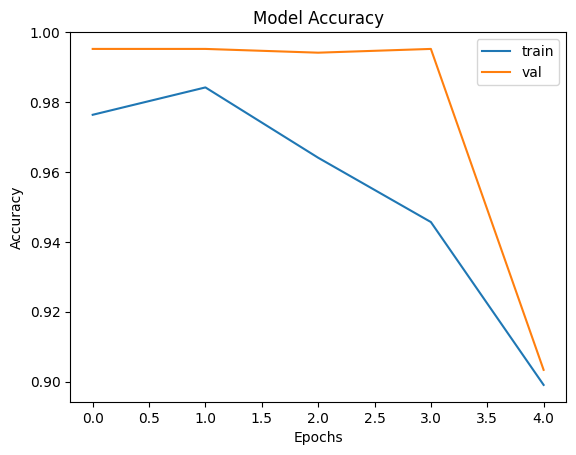

In [54]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc = 'upper right')
plt.show()

# **Model to Be Used for Prediction**